# Sepsis-3 evaluation in the MIMIC-III database

This notebook goes over the evaluation of the new Sepsis-3 guidelines in the MIMIC database, specifically the use of SOFA >= 2 as clinical criteria for sepsis. As the new definition of sepsis includes "life threatening organ dysfunction", and the practical tool used to evaluate this was an increase of hospital mortality of >= 10%, we examine our patient cohort to see if we also observe this hospital mortality increase.

Recall the flowchart from Singer et al. (2016):

![title](img/sepsis-flow.png)

We can see that the *primary* use case of Sepsis-3 is qSOFA >= 2 followed by SOFA >= 2, but this is not required to define sepsis - only SOFA >= 2 is required (where baseline SOFA is assumed to be 0 for patients - of course this may not be the case in those with chronic organ dysfunction).

Furthermore, as we are evaluating a primarily ICU cohort, it makes sense to disregard qSOFA as these patients have already been deemed sick enough to require ICU admission. While we present the performance of qSOFA please keep in mind this is not its primary use case.

In [1]:
from __future__ import print_function

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
from collections import OrderedDict
from statsmodels.formula.api import logit
from IPython.display import display, HTML # used to print out pretty pandas dataframes

from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru

# used to calculate AUROC/accuracy
from sklearn import metrics

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

%matplotlib inline

In [2]:
# load data
df = pd.read_csv('sepsis3-df.csv',sep=',')
df_mdl = pd.read_csv('sepsis3-design-matrix.csv',sep=',')

# define outcome
target_header = "hospital_expire_flag"
y = df[target_header].values == 1

# define the covariates to be added in the MFP model (used for table of AUROCs)
preds_header = ['sirs','qsofa','sofa','mlods']

# Hospital mortality evaluation

In [3]:
# define targets, angus critera
# define "predictions" according to the SEPSIS-3 guidelines:
#  suspicion of infection, qSOFA >= 2, and SOFA >= 2
# this was done in the SQL code - so we pull the values here
yhat = df.sepsis3.values

print('\n SEPSIS-3 guidelines for hospital mortality \n')
# generate evaluation metrics
print('Accuracy = {}'.format(metrics.accuracy_score(y, yhat)))

su.print_cm(y, yhat) # print confusion matrix


 SEPSIS-3 guidelines for hospital mortality 

Accuracy = 0.549329007521

Confusion matrix
      	y=0   	y=1   
yhat=0	  3055	   278	NPV=91.66
yhat=1	  2778	   670	PPV=19.43
   	52.37	70.68	Acc=54.93
   	Spec	Sens


Predictions using various levels of confounder adjustment are calculated in the subfunctions `calc_predictions`:

* `model=None` - the severity scores on their own
* `model='baseline'` - the severity scores in a vanilla regression
* `model='mfp'` -the severity scores in a fractional polynomial regression (calls an R script)

In [4]:
preds = su.calc_predictions(df, preds_header, target_header, model=None)
preds_logreg = su.calc_predictions(df, preds_header, target_header, model='logreg')
preds_mfp = su.calc_predictions(df, preds_header, target_header, model='mfp')

# also get the baseline performance of an MFP model without severity of illness
preds_mfp_baseline = su.calc_predictions(df, preds_header, target_header, model='mfp_baseline')

In [5]:
# reproduce the AUC table

# print out the baseline AUROC of a model without severity of illness
# in Seymour2016, this was 0.58 (validation)
auc_mfp_baseline, ci_mfp_baseline = ru.calc_auc(preds_mfp_baseline, y, with_ci=True, alpha=0.05)
print('Performance of an MFP model without severity of illness: {:0.3f} [{:0.3f}, {:0.3f}]'.format(
    auc_mfp_baseline, ci_mfp_baseline[0], ci_mfp_baseline[1]))
print('\n')

print('AUROC table for unadjusted scores:')
su.print_auc_table(preds, df[target_header].values, preds_header)
print('\n')

print('AUROC table for adjusted scores (using logistic regression):')
su.print_auc_table(preds_logreg, df[target_header].values, preds_header)
print('\n')

print('AUROC table for adjusted scores (using MFP):')
su.print_auc_table(preds_mfp, df[target_header].values, preds_header) # optional argument fixes order of output
print('\n')

su.print_auc_table_to_file(preds, df[target_header].values, preds_header=preds_header,
                           filename='auc-table-mort.csv')

su.print_auc_table_to_file(preds_mfp, df[target_header].values, preds_header=preds_header,
                           filename='auc-table-mort-mfp.csv')

Performance of an MFP model without severity of illness: 0.697 [0.679, 0.714]


AUROC table for unadjusted scores:
     	sirs                	qsofa               	sofa                	mlods               	
sirs 	0.632 [0.614, 0.649]	0.436 [0.414, 0.458]	0.179 [0.161, 0.197]	0.228 [0.207, 0.249]	
qsofa	0.187               	0.618 [0.601, 0.634]	0.271 [0.260, 0.281]	0.356 [0.343, 0.368]	
sofa 	< 0.001               	< 0.001               	0.737 [0.719, 0.755]	0.872 [0.866, 0.877]	
mlods	< 0.001               	< 0.001               	0.263               	0.744 [0.727, 0.761]	


AUROC table for adjusted scores (using logistic regression):
     	sirs                	qsofa               	sofa                	mlods               	
sirs 	0.729 [0.712, 0.746]	0.887 [0.881, 0.893]	0.709 [0.695, 0.722]	0.709 [0.695, 0.723]	
qsofa	0.042               	0.718 [0.701, 0.735]	0.764 [0.753, 0.775]	0.772 [0.761, 0.783]	
sofa 	< 0.001               	< 0.001               	0.783 [0.767, 0.799]	0.924 [0.920,

## ROC curves

### Unadjusted ROC

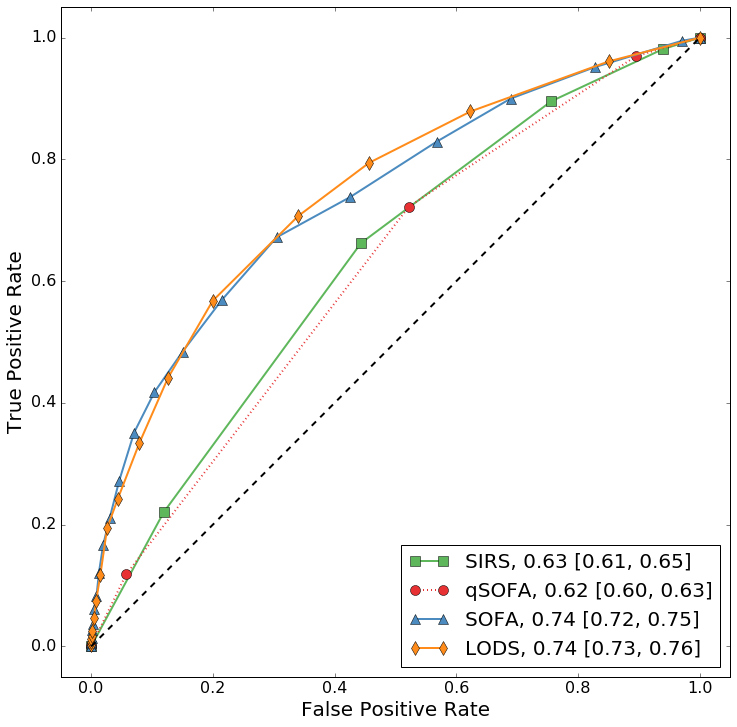

In [11]:
markers = {'qsofa': 'o:', 'sofa': '^-', 'sirs': 's-', 'mlods': 'd-'}
colors = {'qsofa': col[0], 'sofa': col[1], 'sirs': col[2], 'mlods': col[3]}
pred_pretty_text = {'qsofa': 'qSOFA', 'sofa': 'SOFA', 'sirs': 'SIRS', 'mlods': 'LODS'}
# plot the data
ax = plt.figure(figsize=[12,12]).add_subplot(111)

# ROC for each score in preds header
for pred in preds_header:
    fpr, tpr, thr = metrics.roc_curve(y, df[pred].values)
    auc, auc_ci = ru.calc_auc(df[pred].values, y, with_ci=True, alpha=0.05)
    
    plt.plot(fpr, tpr, markers[pred],
             color=colors[pred], linewidth=2, markersize=10,
             label=pred_pretty_text[pred] + ', ' +
             '{:0.2f} [{:0.2f}, {:0.2f}]'.format(auc, auc_ci[0], auc_ci[1]))

plt.legend(loc="lower right", fontsize=20)

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)

# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
#plt.title('ROC against in-hospital mortality',fontsize=14)
plt.show()

### Scores after adjusting in MFP model

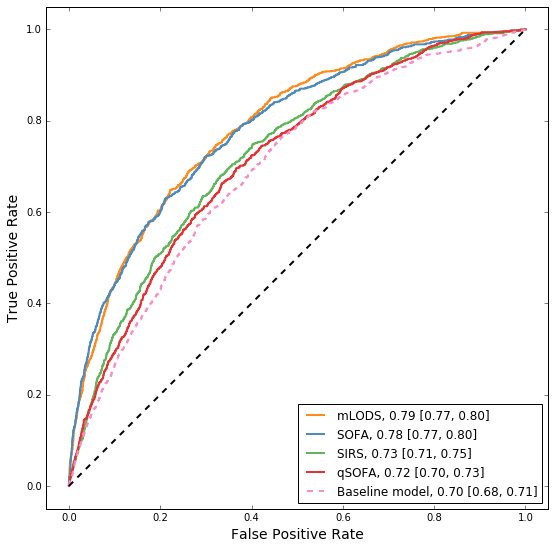

In [7]:
markers = {'qsofa': '-', 'sofa': '-', 'sirs': '-', 'mlods': '-'}
colors = {'qsofa': col[0], 'sofa': col[1], 'sirs': col[2], 'mlods': col[3]}
pred_pretty_text = OrderedDict([['mlods', 'mLODS'],
                               ['sofa', 'SOFA'],
                               ['sirs', 'SIRS'],
                               ['qsofa', 'qSOFA']])
# plot the data
plt.figure(figsize=[9,9])


# ROC for each score in preds header
for pred in pred_pretty_text:
    fpr, tpr, thr = metrics.roc_curve(y, preds_mfp[pred])
    auc, auc_ci = ru.calc_auc(preds_mfp[pred], y, with_ci=True, alpha=0.05)
    
    plt.plot(fpr, tpr, markers[pred],
             color=colors[pred], linewidth=2, markersize=10,
             label=pred_pretty_text[pred] + ', ' +
             '{:0.2f} [{:0.2f}, {:0.2f}]'.format(auc, auc_ci[0], auc_ci[1]))


# baseline MFP model
fpr, tpr, thr = metrics.roc_curve(y, preds_mfp_baseline)
auc, auc_ci = ru.calc_auc(preds_mfp_baseline, y, with_ci=True, alpha=0.05)
    
plt.plot(fpr, tpr, '--',
         color=col[6], linewidth=2, markersize=10,
         label='Baseline model, {:0.2f} [{:0.2f}, {:0.2f}]'.format(auc, auc_ci[0], auc_ci[1]))
plt.legend(loc="lower right")

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)
# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
#plt.title('ROC against in-hospital mortality',fontsize=14)
plt.show()

## Operating point statistics

This section evaluates the standard operating point statistics:

* sensitivity (% of true positives which are correctly classified)
* specificity (% of true negatives which are correctly classified)
* positive predictive value (given a positive prediction is made, what % are correct)
* negative predictive value (given a negative prediction is made, what % are correct)
* F1 score (harmonic mean of sensitivity and PPV)

In [1]:
# sepsis3 defined as qSOFA >= 2 and SOFA >= 2
yhat_dict = OrderedDict([['SOFA', df.sofa.values >= 2],
                        ['SIRS', df.sirs.values >= 2],
                        ['mLODS', df.mlods.values >= 2],
                        ['qSOFA', df.qsofa.values >= 2]])

stats_all = su.get_op_stats(yhat_dict, y)

su.print_op_stats(stats_all)

NameError: name 'OrderedDict' is not defined